<a href="https://colab.research.google.com/github/gowrithampi/deeplearning_with_pytorch/blob/main/Chapter_7_Telling_birds_from_airplanes_Learning_from_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chapter 7 of the book Deep Learning with Pytorch by Eli Stevens, Luca Antiga, Thomas Viehmann


In this chapter we build a simple feed forward neural network that performs an image recognition task. 

CIFAR-10 
60,000 tiny 32x32 RGB images, labelled with an integer corresponding to 10 classes. {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'} 


In [1]:
cifar_classes = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'} 

In [2]:
## Downloading CIFAR 10 Data
## Even if you give a dummy data path that may not really exist, torch vision will download the data
## the dataset module also has a lot of other standard datasets including MNIST, Fashion MNIST
import torch
from torchvision import datasets
data_path = '..data-unversioned/p1ch7/'
##downloading training data
cifar10 = datasets.CIFAR10(data_path, train=True, download = True)
##downloading validation data
cifar10_val = datasets.CIFAR10(data_path, train =False, download = True)


Extracting ..data-unversioned/p1ch7/cifar-10-python.tar.gz to ..data-unversioned/p1ch7/
Files already downloaded and verified


50000

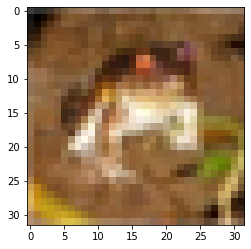

In [3]:
## to see an image from the list 
from matplotlib import pyplot as plt
img,label = cifar10[0]
plt.imshow(img)

len(cifar10)

In the above code we accessed an image using python's slicer [] and also the length of cifar10 using python's len() function. This was possible because, Pytorch's dataset module defines the __getitem__ and __len__ functions. The __getitem__ method returns the image as well as its label, for a specific index from the dataset using the [], that is the slicer operator. 

In [4]:
from torchvision import transforms

In [5]:
dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [6]:
#we instantiate to_tensor, an object of transforms.ToTensor and use that to convert the image into a pytorch tensor 
to_tensor= transforms.ToTensor() 
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [7]:
## The to_tensor transform can be directly passed into the dataset.CIFAR10 constructor
cifar_tensor = datasets.CIFAR10(data_path, train=True, download = False, transform = to_tensor)

In [8]:
## We need to stack these tensors 
cifar_stacked = torch.stack([img_t for img_t, _ in cifar_tensor],dim = 3)

In [9]:
cifar_stacked.shape


torch.Size([3, 32, 32, 50000])

In [10]:
mean = cifar_stacked.mean(dim=(1,2,3))
std = cifar_stacked.std(dim=(1,2,3))

In [11]:
## alternatively we could write it as 
## (3,-1) argument to view means we keep the three channels and merge the remaining dimensions into 1 
cifar_stacked.view(3,-1).mean(dim =1).shape

torch.Size([3])

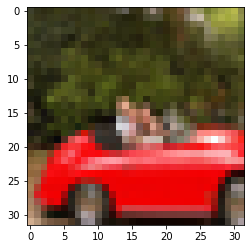

In [12]:
img_sample = cifar_stacked[:,:,:,99]
plt.imshow(img_sample.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


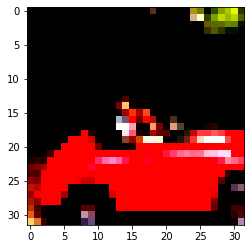

In [13]:
## Now we can normalize the images

## re writing for clarity
imgs_mean = cifar_stacked.mean(dim=(1,2,3))
imgs_std = cifar_stacked.std(dim=(1,2,3))

normalize = transforms.Normalize(mean= imgs_mean, std = imgs_std)

## trying out the transformation 
img_sample_normalized = normalize(img_sample)

## The image now looks different because the RGB values have moved due to normalization
plt.imshow(img_sample_normalized.permute(1,2,0))

## We can load the entire dataset now, with the normalization transformation added in using transforms.Compose

cifar_tensor = datasets.CIFAR10(data_path, train = True, download = False, transform = transforms.Compose([to_tensor,normalize]))



In [14]:
## We need to stack these tensors 
cifar_stacked = torch.stack([img_t for img_t, _ in cifar_tensor],dim = 3)

We will now build a neural network model using pytorch to distinguish between birds and planes in this dataset. 

In [ ]:
## Building the Dataset

## Instead of building an object of the dataset class, in the textbook we are creating a list of images which are either birds or aeroplanes
## label 0 is an aeroplane and label 2 is a bird, from the labels dictionary above. 

## we are going to use the cifar and cifar_val datasets we created before the to_tensor and normalize transforms
## in fact I don't think it is a good idea to normalize the validation set using the mean and standard deviation from the training set, it may lead to data leakage. 

## dictionary to map old labels to new labels
label_map = {0:0, 2:1}
class_labels = ['aeroplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

To build a neural network with the above data, we notice that there are 3(channels) * 32(height) * 32(width) feaures for each image, that is 3072 features for each image. So for a fully connected neural network, the first input layer would have 32 feature, this would be followed by hidden layers that taper the output to just 2, The probability the output is a plane and the probability that the output is a bird(Refer Figure 7.7 in the textbook, page 174) 

In [ ]:
## Creating a fully connected sequential neural network

import torch.nn as nn
n_in = 3072
n_hidden = 512
n_out = 2

model = nn.Sequential(nn.Linear(n_in, n_hidden), nn.Tanh(), nn.Linear(n_hidden,n_out))

list(model.parameters())


In [ ]:
img_sample_reshaped = img_sample.reshape(-1)
output = model(img_sample_reshaped)
output.shape

The problem we are solving is a classification problem, not a regression one. The thermometer calibration problem we solved earlier was a regression problem. 
The output of the classification (bird or airplane) needs to satisfy some conditions. 
1. Each element in the output should be a value in the closed interval [0,1]
2. The sum of the elements in the outputs should add up to 1. 

With the above criteria in mind, we add a softmax layer to our sequential neural network. The softmax function takes an input, an array of size n and returns an output another array of size n. 

The formula for softmax is

$softmax(X_{i}) = e^{X_{i}}/\Sigma_{i}e^{X_{i}}$

The function is monotonic (larger values of Xi leads to a larger softmax) but it is not scale invariant. 
The learning process (gradient descent and updates of parameters) will make sure that the softmax function's outputs mirrors our desired outputs for the different classes. 

In [18]:
## softmax can be calculated along any specified dimension of a tensor
## The torn nn class comes with a predefined nn.Softmax function 

mytensor = torch.tensor([3,4,5,3,4,5],dtype = torch.float).reshape(3,2)
print(mytensor)
print(mytensor.shape)
print(mytensor[0,:])
soft= nn.Softmax(dim =0)
print(soft(mytensor))

tensor([[3., 4.],
        [5., 3.],
        [4., 5.]])
torch.Size([3, 2])
tensor([3., 4.])
tensor([[0.0900, 0.2447],
        [0.6652, 0.0900],
        [0.2447, 0.6652]])
tensor([[3., 4.],
        [5., 3.],
        [4., 5.]])
torch.Size([3, 2])
tensor([3., 4.])
tensor([[0.0900, 0.2447],
        [0.6652, 0.0900],
        [0.2447, 0.6652]])


In [19]:
## our problem can be re written with a softmax layer
model = nn.Sequential(nn.Linear(n_in, n_hidden), nn.Tanh(), nn.Linear(n_hidden,n_out),soft)

In [20]:
output = model(img_sample_reshaped)
output

tensor([0.5423, 0.4577], grad_fn=<SoftmaxBackward>)

## The loss function 

we stop using the MSE loss function and here we use the negative log likelihood loss function. 
The probability the model predicts for the correct class is called the likelihood of the model's parameters. 
We want a loss function that is large when the likelihood is low. The log likelihood function satisfies this criterion. 

$log loss = -\Sigma_{i} (y_{i})log(a_{i}) $

Where $a_{i}$ is the predicted probability for class i , and $y_{i}$ is an indicator variable which is 1 if the sample actually belongs to class i and 0 otherwise. 

Examining the formula, you can see that loss is high if a low probability is predicted for a correct class. 

The cross entropy loss is closely related but different from the log loss. In a multi class classifier the cross entropy loss also penalizes confusion (or high probabilities predicted for the wrong class) The formula for the cross entropy loss is: 

$Crossentropyloss = -\Sigma_{i}[ (y_{i})log(a_{i}) + (1-y_{i})log(1-a_{i})]  $

Note while implementing log loss in pytorch: 
Pytorch's torch.nn module does have a function for calculating log loss that is loss.NLLLoss() but the function accepts an array of log probabilities instead of just probabilities, to calculate the loss. This is because logarithm calculations becomes unstable as values get very close to zero, and we need optimized functions for calculating logarithms. 

Therefore in the last layer of our network we use nn.LogSoftmax instead of nn.Softmax, nn.LogSoftmax returns the logs of the softmax probabilites instead of the probabilities themselves and is optimized to perform this computation. 


In [22]:
## Re writing our network 

model = model = nn.Sequential(nn.Linear(n_in, n_hidden), nn.Tanh(), nn.Linear(n_hidden,n_out),nn.LogSoftmax())